# Image classification with Convolutional Neural Networks

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
from fastai.imports import *
from fastai.model import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
path = "data/dogscats/"

## First look at cat pictures

In [4]:
os.listdir(path)

['valid', 'train', 'tmp', 'sample', 'models', 'test1']

In [5]:
os.listdir(f'{path}valid')

['cats', 'dogs']

In [6]:
files = os.listdir(f'{path}valid/cats/')[:5]
files

['cat.2393.jpg',
 'cat.8031.jpg',
 'cat.9309.jpg',
 'cat.8488.jpg',
 'cat.11957.jpg']

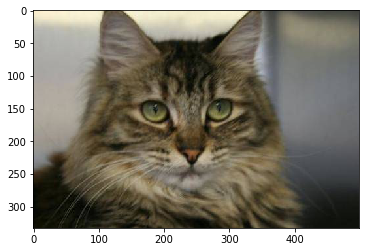

In [7]:
img = plt.imread(f'{path}/valid/cats/{files[3]}')  # Python 3.6 format string
plt.imshow(img)

In [8]:
img.shape

(333, 499, 3)

In [9]:
img[:2,:2]

array([[[249, 236, 204],
        [249, 236, 204]],

       [[248, 235, 203],
        [249, 236, 204]]], dtype=uint8)

## First model: finetuning a resnet34 that was pretrained on ImageNet

In [11]:
sz = 224
arch = resnet34
data = ImageClassifierData.from_paths(path, tfms = tfms_from_model(arch, sz))  # tfms ensures (mean,stdev) of (0,1)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [28]:
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy                     
    0      0.059975   0.029545   0.9895    
    1      0.038143   0.029309   0.9875                       
    2      0.045194   0.03272    0.9865                       



[array([0.03272]), 0.9865]

## Analyzing results:

In [29]:
data.classes

['cats', 'dogs']

In [30]:
# labels for the validation data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [31]:
# Let's calculate oredictions for the validation set (in logscale)
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [32]:
log_preds[:10]

array([[ -0.00028,  -8.18535],
       [ -0.00012,  -9.03626],
       [ -0.     , -12.42719],
       [ -0.00006,  -9.77362],
       [  0.     , -16.88233],
       [ -0.00034,  -7.97725],
       [ -0.     , -14.63643],
       [ -0.00008,  -9.40176],
       [ -0.00016,  -8.73397],
       [ -0.00041,  -7.80892]], dtype=float32)

In [33]:
preds = np.argmax(log_preds, axis = 1)

In [34]:
probs = np.exp(log_preds[:,1]) # Probability that a picture shows a dog

In [35]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], size=4, replace=False)

In [36]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

In [37]:
def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y) ==  is_correct)

In [38]:
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [39]:
def plots(imgs, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(imgs[i])

In [40]:
def plot_val_with_title(idxs, title, ds=data.val_ds):
    imgs = [np.array(PIL.Image.open(path+ds.fnames[x])) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows = 1, titles=title_probs)

### 1. A few correct labels at random

Correctly classified


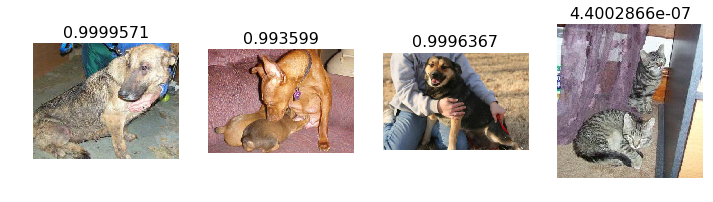

In [41]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

### 2. A few incorrect labels at random

Incorrectly classified


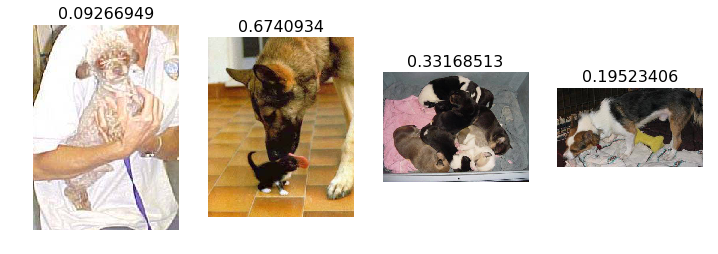

In [42]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

### 3. The Most correct cats and dogs

Most correct cats


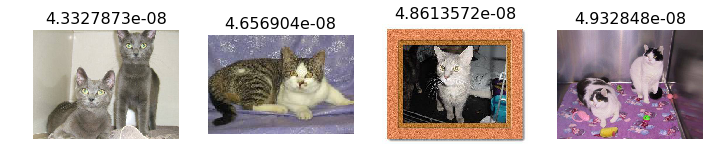

In [43]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


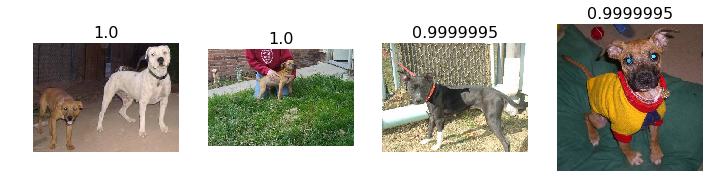

In [44]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

### 4. The most incorrect cats and dogs

Most incorrect cats


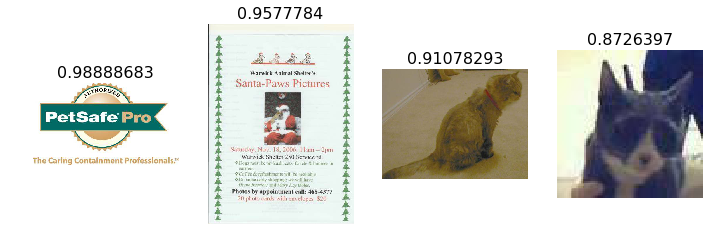

In [45]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


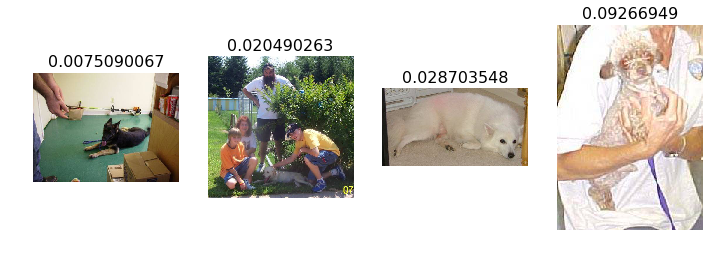

In [46]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

### 5. Most uncertain

In [47]:
most_uncertain = np.argsort(np.abs(probs-0.5))[:4]

Most uncertain predictions


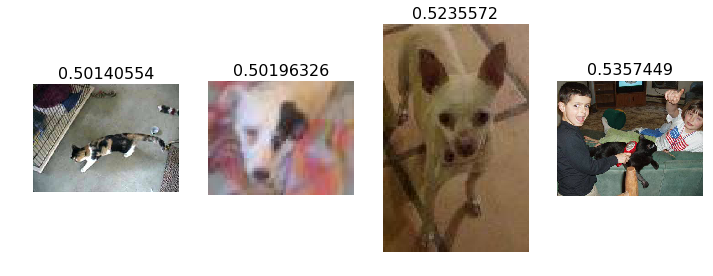

In [48]:
plot_val_with_title(most_uncertain, "Most uncertain predictions")

The left dog could be wrongly classified because the algorithm only looks at a square of the picture, which in this case is critical because the picture is very long stretched. This means we might have to use image augmentation.

## Choosing a learning rate

In [32]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [33]:
lrf = learn.lr_find()

 83%|████████▎ | 299/360 [00:04<00:00, 63.94it/s, loss=0.469] 


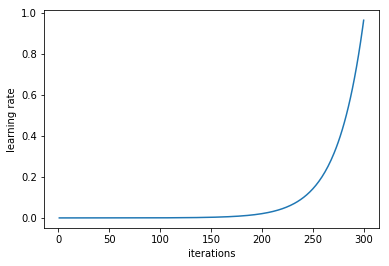

In [34]:
learn.sched.plot_lr()

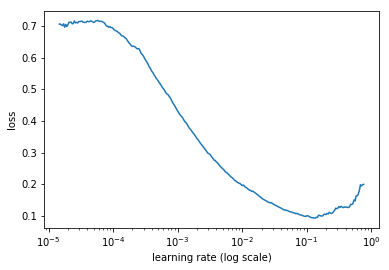

In [35]:
learn.sched.plot()

In [36]:
lr = 1e-2

## Improving the model

### Data augmentation

In [37]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [38]:
def get_augs(i):
    data = ImageClassifierData.from_paths(path, bs=6, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[i]

In [39]:
ims = np.stack([get_augs(3) for i in range(6)])

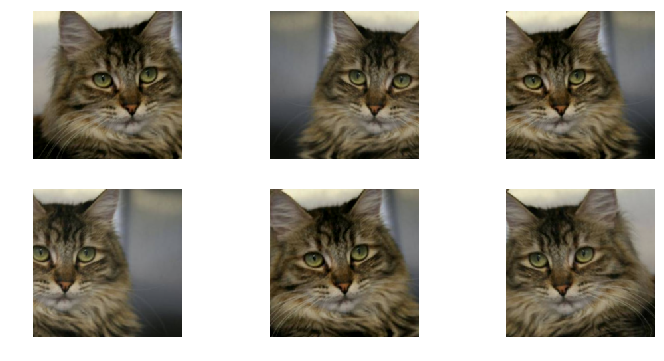

In [40]:
plots(ims,rows=2)

In [41]:
data = ImageClassifierData.from_paths(path, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)  
# Set learn.precompute = True since otherwise the precomputations 
# are all the same regardless of data augmentation
# Precomputations are in 'tmp' in data folder

In [42]:
learn.fit(1e-2, 3)

epoch      trn_loss   val_loss   accuracy                     
    0      0.048882   0.028717   0.989     
    1      0.048637   0.029238   0.99                         
    2      0.043272   0.02877    0.989                        



[array([0.02877]), 0.989]

### Stochastic gradient descend with restarts (SGDR) and cosine annealing

Learning rate we choose is the maximum lr the scheduler uses. Cycle length means restarting after every epoch

In [43]:
learn.fit(1e-2, n_cycle=3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.037883   0.028055   0.99      
    1      0.038545   0.027518   0.99                         
    2      0.03991    0.026889   0.9885                       



[array([0.02689]), 0.9885]

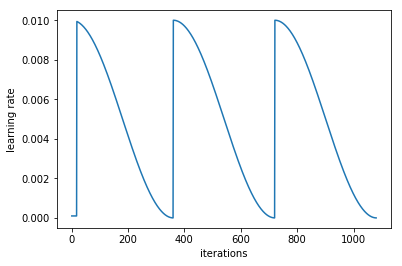

In [44]:
learn.sched.plot_lr()

In [45]:
learn.save('224_lastlayer')

In [52]:
learn.load('224_lastlayer')

### Fine-tuning by unfreezing earlier layers and differential learning rate annealing

* First layers probably need to be adjusted less than later layers since they learned more general features like edges or corners => Use array of learning rates

* `cycle_mult` increases the "epochs per restart" since otherwise, we might restart to early, before actually reaching the local minimum. Look at the previous learning. The training loss did not decrease any further because we reset to early.
* Do cycles until it starts to overfit

In [50]:
learn.unfreeze()

You might want to use `learn.bn_freeze(True)` to not update the batch norm moving averages (assuming the chosen architecture uses batch norm layers and the images are similar to what the network has been pretrained on).

In [51]:
lr_array = np.array([1e-4, 1e-3, 1e-2])  # If pictures are unlike imagenet, train the earlier layers more as well

In [55]:
learn.fit(lr_array, n_cycle=3, cycle_len=1, cycle_mult=2)
# learn.fit(lr_array, n_cycle=3, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.04972    0.03122    0.9875    
    1      0.039806   0.021816   0.993                        
    2      0.033895   0.022968   0.9895                       
    3      0.032002   0.021759   0.991                        
    4      0.028396   0.020535   0.991                        
    5      0.020819   0.021884   0.9865                       
    6      0.016823   0.018389   0.992                        



[array([0.01839]), 0.992]

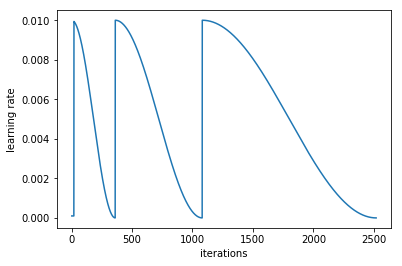

In [56]:
learn.sched.plot_lr()

In [57]:
learn.save('224_all')

In [52]:
learn.load('224_all')

## Test time augmentation
Predictions are made on the base of more than one picture. By default, it uses the original image along with 4 randomly augmented versions.

In [53]:
log_preds, y = learn.TTA()

In [54]:
probs = np.mean(np.exp(log_preds), axis=0)

In [55]:
probs[:5]

array([[0.99997, 0.00003],
       [1.     , 0.     ],
       [1.     , 0.     ],
       [0.99994, 0.00006],
       [1.     , 0.     ]], dtype=float32)

In [57]:
preds = np.argmax(probs, axis=1)
acc = np.mean(preds==y, axis=0)

In [58]:
acc

0.994

## Analyzing results

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [66]:
cm

array([[995,   5],
       [  7, 993]])

[[995   5]
 [  7 993]]


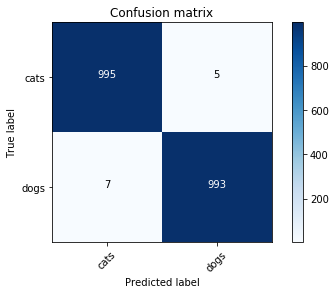

In [61]:
plot_confusion_matrix(cm, data.classes)

## Looking at pictures again
For most of the wrongly classified images, it is understandable why they are hard to classify

In [63]:
probs = probs[:,1]

Most incorrect cats


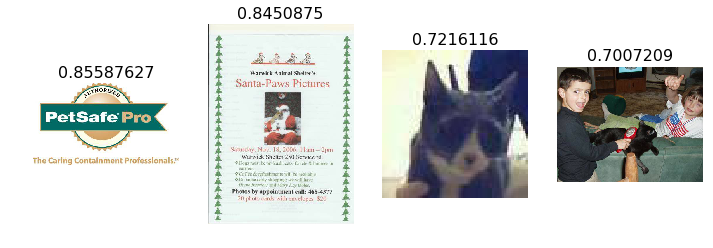

In [64]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


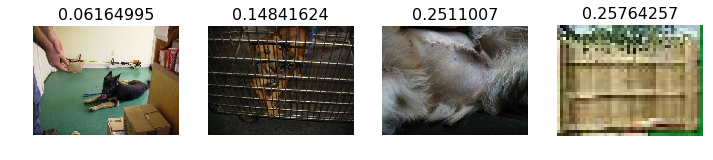

In [65]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")